# 摘要

# 理论模型

螺纹钢是热轧带肋钢筋的俗称，亦称变形钢筋或异形钢筋。其与光圆钢筋的区别为表面带有纵肋和横肋，通常带有两道纵肋和沿长度方向均匀分布的横肋。螺纹钢属于小型钢材，主要用于钢筋混凝土建筑构件的骨架，广泛用于房屋、桥梁、道路等土建工程建设。

![螺纹钢](.\images\螺纹钢.PNG)

## 分类

以**几何形状**分类，根据横肋的截面形状及肋的间距不同进行分类或分型，如英国标准（BS4449）中，将螺纹钢分为Ⅰ型、Ⅱ型。这种分类方式主要反映螺纹钢的握紧性能。

以**性能**分类（级），如我国标准（GB1499.2-2007）中，按强度级别（屈服强度）将螺纹钢分为3个等级；日本工业标准（JISG3112）中，按综合性能将螺纹钢分为5个种类。

按**用途**分类，如分为钢筋混凝土用普通钢筋及钢筋混凝土用热处理钢筋等。

我国螺纹钢执行的标准是 GB1499.2-2007，分为普通热轧钢筋和细晶粒热轧钢筋以及较高要求的抗震钢筋：
* 普通热轧钢筋是按热轧状态交货的钢筋。其金相组织主要是铁素体加珠光体，不得有影响使用性能的其他组织存在。普通热轧带肋钢筋牌号由 HRB 和屈服强度特征值构成；H、R、B 分别为热轧（Hotrolled）、带肋（Ribbed）、钢筋（Bars）三个词的英文首位字母；普通热轧钢筋牌号分为 HRB335、HRB400、HRB500 三个牌号。
* 细晶粒热轧钢筋是指在热轧过程中，通过控轧和控冷工艺形成的细晶粒钢筋。其金相组织主要是铁素体加珠光体，不得有影响使用性能的其他组织存在，晶粒度不粗于 9 级。细晶粒热轧带肋钢筋牌号由 HRBF 和屈服强度特征值构成。F 为细（Fine）的英文首位字母。细晶粒热轧钢筋牌号分为 HRBF335、HRBF400、HRBF500 三个牌号。
* 抗震钢筋：标识是在已有牌号后面加 E（例如 HRB400E、HRBF400E），抗震钢筋除应满足标准所规定普通钢筋所有性能指标外，还应满足以下三个要求：1、抗震钢筋的实测抗拉强度与实测屈服强度特征之比不小于1.25；2、钢筋的实测屈服强度与标准规定的屈服强度特征值之比不大于1.30；3、钢筋的最大力总伸长不小于9%。


## 生产

螺纹钢由小型轧机生产。生产工艺流程为：

步进式加热炉——粗轧机——中轧机——精轧机——水冷装置——冷床——冷剪——自动计数装置——打捆机——卸料台架

## 价格影响因素

**宏观经济**

螺纹钢是典型的工业产品，与工业发展和经济增长密切相关。主要指标有：第二产业的当季同比。

螺纹钢主要用于土建工程建设，因此与基础建设投资密切相关。主要指标有：固定资产投资完成额。

**供需平衡**

库存反映供需平衡情况。

**下游产品**

房地产是螺纹钢用量的一个重要方向。主要指标有：房地产开发投资完成额，房屋新开工面积，房屋施工面积等。

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
sys.path.append("D:\\HST\\QuantStudio")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from WindPy import w
import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

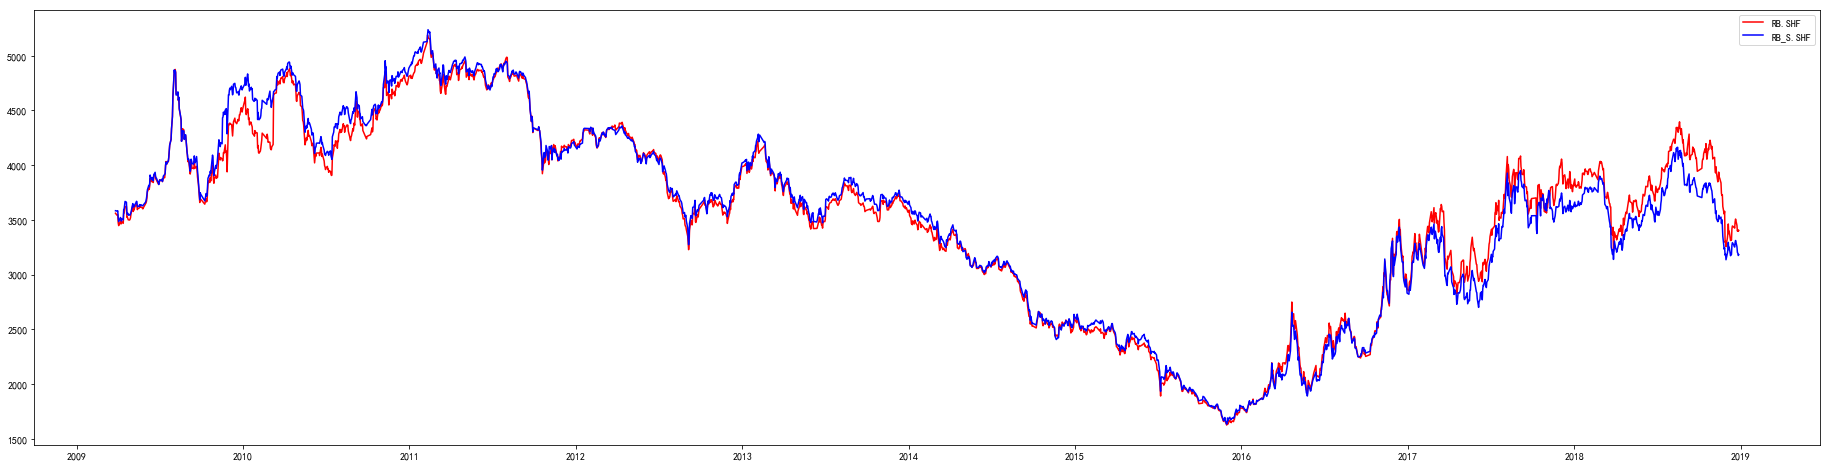

In [2]:
# 参数设置和数据准备
Exchange = "SHFE"
MID, SID = "RB.SHF", "RB_S.SHF"# 主力合约, 次主力合约
StartDT = dt.datetime(2009, 3, 27)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[MID, SID], dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
CCPrice = FT.readData(factor_names=[PriceFactor], ids=[MID, SID], dts=DTs).iloc[0]
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
WDB.disconnect()
# 对连续合约的价格进行调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in CCPrice.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, CCPrice.columns]

Fig, Axes = plt.subplots(1, 1, figsize=(32, 8))
Axes.plot(CCPrice.index, CCPrice.values[:, 0], color='r', label=CCPrice.columns[0])
Axes.plot(CCPrice.index, CCPrice.values[:, 1], color='b', label=CCPrice.columns[1])
Axes.legend(loc='best');

# 附录

## 期货

![螺纹钢期货合约](.\images\螺纹钢期货合约.PNG)

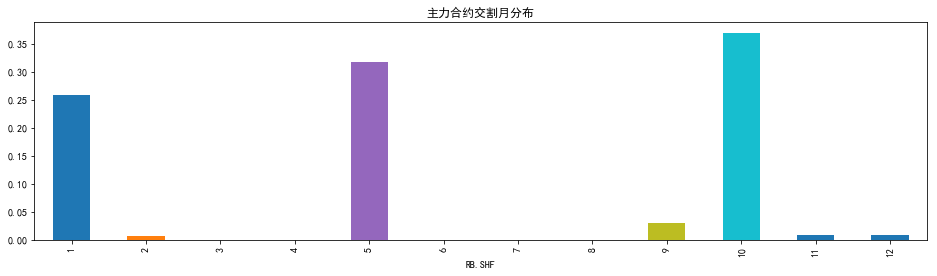

In [3]:
# 获取主力合约的月合约的交割月分布
import re
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
ExpiryMonthDistribution = ExpiryMonth.groupby(by=ExpiryMonth).count() / ExpiryMonth.shape[0]
ExpiryMonthDistribution = ExpiryMonthDistribution.loc[np.arange(1, 13)].fillna(0)
ExpiryMonthDistribution.plot(kind="bar", figsize=(16, 4), title="主力合约交割月分布");

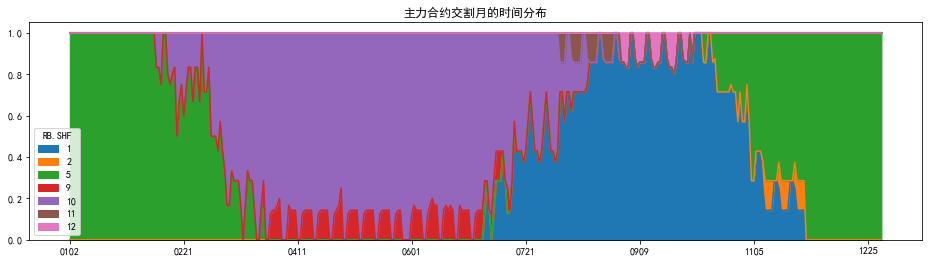

In [4]:
# 获取主力合约切换的时间分布
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
MonthDay = pd.Series([iDT.strftime("%m%d") for iDT in ExpiryMonth.index], index=ExpiryMonth.index)
ExpiryMonthDistributionPerYear = ExpiryMonth.groupby(by=[ExpiryMonth, MonthDay]).count().unstack()
ExpiryMonthDistributionPerYear = (ExpiryMonthDistributionPerYear / ExpiryMonth.groupby(by=MonthDay).count()).T
ExpiryMonthDistributionPerYear = ExpiryMonthDistributionPerYear.fillna(0)
Fig, Axes = plt.subplots(1, 1, figsize=(16, 4))
Axes = ExpiryMonthDistributionPerYear.plot(kind="area", ax=Axes, title="主力合约交割月的时间分布")
xTicks = Axes.get_xticks().astype(np.int)
xTickLabels = np.full(shape=xTicks.shape, fill_value="", dtype="O")
Mask = ((xTicks>=0) & (xTicks<ExpiryMonthDistributionPerYear.shape[0]))
xTickLabels[Mask] = ExpiryMonthDistributionPerYear.index.values[xTicks[Mask].tolist()]
Axes.set_xticklabels(xTickLabels);